In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import os
os.chdir("/content/gdrive/MyDrive")
os.listdir()

['Colab Notebooks', 'train_images', 'csv', 'SSD']

In [ ]:
%matplotlib inline
import numpy as np # Linear Algebra
import gc
import pandas as pd # Data Processing, CSV file I/O (e.g. pd.read_csv)

import torch
from torchvision import models
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
import torchvision


from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import os
import json
import re
from joblib import Parallel,delayed
import random
from math import sqrt
import warnings
warnings.filterwarnings("ignore")
import timeit

from SSD.ssd import SSD
from SSD.loss import MultiBoxLoss
from SSD.dataset import SSDDataset
from SSD.iou import bb_intersection_over_union

# Things to do to improve results
- Scale Prediction
- Add GIOU
- Add Decoder
- Add noise in the dataset

# Dataset

In [ ]:
data=pd.read_csv("csv/train.csv")
data.head()

,image_name,label,template_name,xmin,ymin,xmax,ymax
0,0181 copie.jpg,0181 copie_0,0181 copie_0_0.jpg,216,696,545,1040
1,0181 copie.jpg,0181 copie_0_flipped,0181 copie_0_flipped_0.jpg,852,687,1210,1038
2,0181 copie.jpg,0181 copie_1,0181 copie_1_0.jpg,557,701,861,1080
3,0181 copie.jpg,0181 copie_2,0181 copie_2_0.jpg,194,1201,419,1380
4,0181 copie.jpg,0181 copie_2,0181 copie_2_1.jpg,1019,1201,1275,1379


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4467 entries, 0 to 4466
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image_name     4467 non-null   object
 1   label          4467 non-null   object
 2   template_name  4467 non-null   object
 3   xmin           4467 non-null   int64 
 4   ymin           4467 non-null   int64 
 5   xmax           4467 non-null   int64 
 6   ymax           4467 non-null   int64 
dtypes: int64(4), object(3)
memory usage: 244.4+ KB


In [ ]:
image_names=list(data['image_name'].unique())
imageArray=pd.DataFrame({"image_name":[],"image_array":[]})
for im in image_names:
  img=Image.open("train_images/"+im)
  imageArray=pd.concat([imageArray,pd.DataFrame({"image_name":[im],"image_array":[np.array(img)]})])
  del img

In [ ]:
imageArray.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18 entries, 0 to 0
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image_name   18 non-null     object
 1   image_array  18 non-null     object
dtypes: object(2)
memory usage: 432.0+ bytes


In [ ]:
# Merge the data with imageData to get array of the images
#data=pd.merge(data,imageData,on="image_name")

In [ ]:
# We don't need to save the image array for every cropped image, we will save the information about the co-ordinates
imageData=pd.DataFrame({"image_name":[],"x_min":[],"y_min":[],"x_max":[],"y_max":[]})
imageData["image_name"]=imageArray['image_name']

In [ ]:
imageData["x_min"]=imageData["image_name"].apply(lambda x:0)
imageData["y_min"]=imageData["image_name"].apply(lambda x:0)
imageData["x_max"]=imageData["image_name"].apply(lambda x:
                                                 imageArray[imageArray["image_name"]==x]["image_array"][0].shape[1])
imageData["y_max"]=imageData["image_name"].apply(lambda x:
                                                 imageArray[imageArray["image_name"]==x]["image_array"][0].shape[0])

In [ ]:
img_name=imageData['image_name'].unique()[1]
original_image_name=img_name
# Image
crop_coord=imageData[imageData['image_name']==img_name][["x_min","y_min","x_max","y_max"]].values[0]
image=imageArray[imageArray['image_name']==original_image_name]['image_array'].values[0][crop_coord[1]:crop_coord[3],
                                                                crop_coord[0]:crop_coord[2],:]

In [ ]:
# Encode the labels with Int
labels=data["label"]
le=LabelEncoder()
data['label']=le.fit_transform(labels)+1

In [ ]:
def random_crop(num,im):
    """ Randomly Crop an Image with a fixed size """
    global imageData
    global data
    img=Image.open("train_images/"+im)
    w,h=img.width,img.height
    #img=np.array(img)
    #new_dataset=dataset.copy()
    #new_imageData=image_dataset.copy()
    if w>2000:
        new_w=640
    if h>2000:
        new_h=640
    new_x=np.random.randint(0,w-2*new_w)
    new_y=np.random.randint(0,h-new_h)

    # New cropped Image
    #new_img=img[new_y:new_y+new_h,new_x:new_x+new_w]
    name=im.split(".")[0] +"_cropped_"+str(num)+".jpg"
    boxes=[]
    #pil_image=Image.fromarray(new_img)
    image_dataset=data[data['image_name']==im]
    imageData=pd.concat([imageData,pd.DataFrame({'image_name':[name],"x_min":[new_x],
                                                 "y_min":[new_y],"x_max":[new_x+new_w],
                                                 "y_max":[new_y+new_h]})],axis=0)
    
    #start = timeit.default_timer()

    for i in range(len(image_dataset)):
        change=False
        tm=image_dataset.iloc[i]
        area_old=(tm['xmax']-tm['xmin'])*(tm['ymax']-tm['ymin'])
        if tm['xmin']>=new_x and tm['ymin']>=new_y and tm['xmax']<new_x+new_w and tm['ymax']<new_y+new_h:
            change=True
            tm['xmin']-=new_x
            tm['ymin']-=new_y
            tm['xmax']-=new_x
            tm['ymax']-=new_y
        elif tm['xmax']<new_x+new_w and tm['ymax']<new_y+new_h and tm['xmax']>=new_x and tm['ymax']>=new_y:
            change=True
            tm['xmax']-=new_x
            tm['ymax']-=new_y
            if tm['xmin']<=new_x:
              tm['xmin']=0
            else:
              tm['xmin']-=new_x
            if tm['ymin']<=new_y:
              tm['ymin']=0
            else:
              tm['ymin']-=new_y
        
        elif tm['xmin']>new_x and tm['ymin']>new_y and tm['xmin']<=new_x+new_w and tm['ymin']<=new_y+new_h:
            change=True
            tm['xmin']-=new_x
            tm['ymin']-=new_y
            if tm['xmax']>=new_x+new_w:
              tm['xmax']=new_w-1
            else:
              tm['xmax']-=new_x
            if tm['ymax']>=new_y+new_h:
              tm['ymax']=new_h-1
            else:
              tm['ymax']-=new_y
        area_new=(tm['xmax']-tm['xmin'])*(tm['ymax']-tm['ymin'])
        if change and area_new/area_old>0.75:
            #tm['imageData']=new_img
            temp=pd.DataFrame({"image_name":[name],"label":[tm["label"]],
                               "template_name":[tm["template_name"]],"xmin":[tm["xmin"]],
                               "ymin":[tm["ymin"]],"xmax":[tm["xmax"]],
                               "ymax":[tm["ymax"]]})
            data=pd.concat([data,temp],axis=0)

        
        gc.collect()
    #stop = timeit.default_timer()
    #print(f'Time taken for Image {im} Number {num}: ', stop - start,"\n")
        

In [ ]:
def plot_box(data,img_no=1):
    img_name=data['image_name'].unique()[img_no]
    if "_" in img_name:
      original_image_name=img_name.split("_")[0]+".jpg"
    else:
      original_image_name=img_name
    boxes=data[data['image_name']==img_name][['xmin','ymin','xmax','ymax']].values
    # Image
    crop_coord=imageData[imageData['image_name']==img_name][["x_min","y_min","x_max","y_max"]].values[0]
    image=imageArray[imageArray['image_name']==original_image_name]['image_array'].values[0][crop_coord[1]:crop_coord[3],
                                                                crop_coord[0]:crop_coord[2],:]

    image=Image.fromarray(image)

    # Draw rectangle
    img1=ImageDraw.Draw(image)
    for bx in boxes:
      img1.rectangle(tuple(bx),outline="red")
    
    return image

In [ ]:
"""for im in image_names[5:10]:
  #Parallel(n_jobs=5)(delayed(random_crop)(i,im) for i in range(1,100))
  start = timeit.default_timer()
  for i in range(1,100):
      random_crop(i,im)
  stop = timeit.default_timer()
  print(f'Time taken for Image {im} : ', (stop - start)/60," minutes ","\n")
  print(len(imageData),len(data))"""

'for im in image_names[5:10]:\n  #Parallel(n_jobs=5)(delayed(random_crop)(i,im) for i in range(1,100))\n  start = timeit.default_timer()\n  for i in range(1,100):\n      random_crop(i,im)\n  stop = timeit.default_timer()\n  print(f\'Time taken for Image {im} : \', (stop - start)/60," minutes ","\n")\n  print(len(imageData),len(data))'

In [ ]:
#imageData.to_csv("/content/gdrive/MyDrive/csv/imageData_2.csv",index=None)

In [ ]:
#data.to_csv("/content/gdrive/MyDrive/csv/data_2.csv",index=None)

In [ ]:
imageData=pd.read_csv("/content/gdrive/MyDrive/csv/imageData_2.csv")
data=pd.read_csv("/content/gdrive/MyDrive/csv/data_2.csv")

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10630 entries, 0 to 10629
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image_name     10630 non-null  object
 1   label          10630 non-null  int64 
 2   template_name  10630 non-null  object
 3   xmin           10630 non-null  int64 
 4   ymin           10630 non-null  int64 
 5   xmax           10630 non-null  int64 
 6   ymax           10630 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 581.5+ KB


In [ ]:
imageData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 513 entries, 0 to 512
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_name  513 non-null    object
 1   x_min       513 non-null    int64 
 2   y_min       513 non-null    int64 
 3   x_max       513 non-null    int64 
 4   y_max       513 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 20.2+ KB


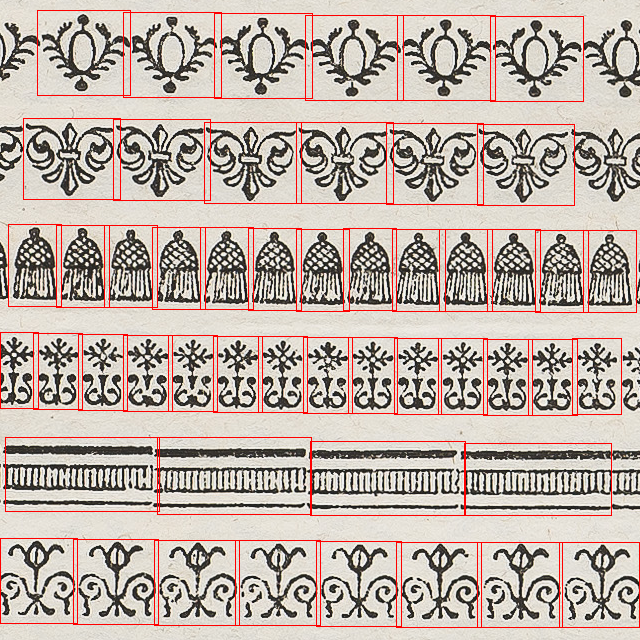

In [ ]:
plot_box(data,408)

In [ ]:
class SSDDataset(Dataset):
    def __init__(self, data, imageData, imageArray, is_test=False, transform=None):
        #self.annotation_folder_path = csv_path
        self.data=data # Contains the information about bounding boxes
        self.imageData=imageData # Contains the coordinate of the cropped images
        self.imageArray=imageArray # Contains the arrays of the original 18 images
        self.all_images=self.data['image_name'].unique()
        self.transform = transform
        self.is_test = is_test
        
    def __getitem__(self, idx):
        img_name = self.all_images[idx]
        if "_" in img_name:
          original_img_name=img_name.split("_")[0]+".jpg"
        else:
          original_img_name=img_name
        coord=self.imageData[self.imageData['image_name']==img_name][["x_min","y_min","x_max","y_max"]].values[0]
        img = Image.fromarray(self.imageArray[self.imageArray['image_name']==original_img_name]['image_array'].values[0][
            int(coord[1]):int(coord[3]),int(coord[0]):int(coord[2])])
        img = img.convert('RGB')
        
        if not self.is_test:
            annotations=self.data[self.data['image_name']==img_name]

            self.box = self.get_xy(annotations)

            self.new_box = torch.FloatTensor(self.box_resize(self.box, img)).cuda()
            if self.transform is not None:
                img = self.transform(img)
            

            self.labels=torch.FloatTensor(annotations['label'].values).cuda()

            """# Encode the labels with Int
            self.le=LabelEncoder()
            self.labels=torch.FloatTensor(self.le.fit_transform(self.labels))"""

            return img, self.new_box, self.labels
        else:
            return img
    
    def __len__(self):
        return len(self.all_images)
        
    def get_xy(self, annotation):
        boxes=torch.FloatTensor(annotation[['xmin','ymin','xmax','ymax']].values)
        return boxes
        
    def box_resize(self, box, img, dims=(300, 300)):
        old_dims = torch.FloatTensor([img.width, img.height, img.width, img.height]).unsqueeze(0)
        new_box = box / old_dims
        new_dims = torch.FloatTensor([dims[1], dims[0], dims[1], dims[0]]).unsqueeze(0)
        #new_box = new_box * new_dims
        
        return new_box
    
    def collate_fn(self, batch):
        """
        :param batch: an iterable of N sets from __getitem__()
        :return: a tensor of images, lists of varying-size tensors of bounding boxes, labels, and difficulties
        """

        images = list()
        boxes = list()
        labels = list()
#         difficulties = list()

        for b in batch:
            images.append(b[0])
            boxes.append(b[1])
            labels.append(b[2])
#             difficulties.append(b[3])

        images = torch.stack(images, dim=0)

        return images, boxes, labels  # tensor (N, 3, 300, 300), 3 lists of N tensors each

In [ ]:
x_train,x_test=train_test_split(data,test_size=0.15,random_state=1)

In [ ]:
tsfm = transforms.Compose([
    transforms.Resize([300,300]),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

# Batch Size
BS=8

In [ ]:
train_ds = SSDDataset(x_train, imageData,imageArray, transform=tsfm)
train_dl = DataLoader(train_ds, batch_size=BS, shuffle=True, collate_fn=train_ds.collate_fn)

valid_ds = SSDDataset(x_test,imageData,imageArray, transform=None)
valid_dl = DataLoader(valid_ds, batch_size=BS, shuffle=True, collate_fn=valid_ds.collate_fn)

# Train

In [64]:
N_CLASSES=data['label'].nunique()+1 # +1 for background
EPOCH = 10
LR = 0.001
momentum = 0.9  # momentum
weight_decay = 5e-4  # weight decay
print_feq = 100

In [ ]:
model = SSD(n_classes=N_CLASSES).cuda()
criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy).cuda()
#optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=momentum, weight_decay=weight_decay)
optimizer = torch.optim.Adam(model.parameters(), lr=LR,  weight_decay=weight_decay)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth




Loaded base model.



In [ ]:
criterion.l1

SmoothL1Loss()

In [ ]:
model.load_state_dict(torch.load("/content/gdrive/MyDrive/SSD/model_1.pth"))

<All keys matched successfully>

In [ ]:
from tqdm import tqdm
import time
for epoch in range(1, EPOCH+1):
    model.train()
    train_loss = []
    time_start=time.time()
    for step, (img, boxes, labels) in enumerate(train_dl):
        time_1 = time.time()
        img = img.cuda()
        # Box = torch.cat(box)
        boxes = [box.cuda() for box in boxes]
        # Label = torch.cat(label)
        labels = [label.cuda() for label in labels]
        
        pred_loc, pred_sco = model(img)
        
        loss = criterion(pred_loc, pred_sco, boxes, labels)
        
        # Backward prop.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Losses.update(loss.item(), images.size(0))
        train_loss.append(loss.item())
    time_end=time.time()
    total_time=str((time_end-time_start)//60)+" minutes and "+ str((time_end-time_start)%60)+" seconds "
        
        
    print("Time:",total_time, ' epoch: ', epoch, '/', EPOCH,
            'train loss:', '{:.4f}'.format(np.mean(train_loss)))

Time: 2.0 minutes and 6.870143890380859 seconds   epoch:  1 / 10 train loss: 1.0725
Time: 2.0 minutes and 5.046943664550781 seconds   epoch:  2 / 10 train loss: 1.0771
Time: 2.0 minutes and 3.9700047969818115 seconds   epoch:  3 / 10 train loss: 1.0078


In [65]:
torch.save(model.state_dict(),"/content/gdrive/MyDrive/SSD/model_loss.pth")

# test

In [47]:
model.eval();
#del train_ds, train_dl, valid_ds, valid_dl

In [57]:
from random import randint
def non_max_supression(box,label,score):
    new_box=[]
    new_score=[]
    new_label=[]

    for i,ob in enumerate(box):
        update=True
        for j,nb in enumerate(new_box):
            if bb_intersection_over_union(ob,nb)>0.2:
                if new_label[j]==label[i] and new_score[j]<score[i]:
                    new_box[j]=ob
                    new_score[j]=score[i]
                    update=False
                    break
                else:
                    update=False
                    break
        if update:
            new_box.append(ob)
            new_score.append(score[i])
            new_label.append(label[i])
    new_box=[np.hstack(i) for i in new_box]
    return new_box,new_label,new_score


def test(image_dir):
    if type(image_dir)==str:
      origin_img = Image.open(image_dir).convert('RGB')
    else:
      origin_img=Image.fromarray(image_dir)
    img = tsfm(origin_img)

    img = img.cuda()
    predicted_locs, predicted_scores = model(img.unsqueeze(0))
    det_boxes, det_labels, det_scores = model.detect_objects(predicted_locs, predicted_scores, min_score=0.2,
                                                                max_overlap=0.5, top_k=200)
    det_boxes = det_boxes[0].to('cpu')

    origin_dims = torch.FloatTensor([origin_img.width, origin_img.height, origin_img.width, origin_img.height]).unsqueeze(0)
    det_boxes = det_boxes * origin_dims

    new_boxes,new_labels,new_scores=non_max_supression(det_boxes.detach().cpu().numpy().reshape(-1,2,2),
                                                       det_labels[0].detach().cpu().numpy(),det_scores[0].detach().cpu().numpy())

    annotated_image = origin_img
    draw = ImageDraw.Draw(annotated_image)
    for i,bx in enumerate(new_boxes):
        #box_location = bx.tolist()
        box_location=bx
        draw.rectangle(xy=box_location, outline='red')
        draw.rectangle(xy=list(map(lambda x:x+1, box_location)), outline='red')
    return annotated_image,new_labels,new_scores,new_boxes

In [62]:
all_images=data["image_name"].unique()
image_name=all_images[26]
original_image_name=image_name.split("_")[0]+".jpg"
crop_coord=imageData[imageData['image_name']==image_name][["x_min","y_min","x_max","y_max"]].values[0]
img=imageArray[imageArray['image_name']==original_image_name]['image_array'].values[0][crop_coord[1]:crop_coord[3],
                                                                crop_coord[0]:crop_coord[2],:]
image,labels,scores,boxes=test(img)

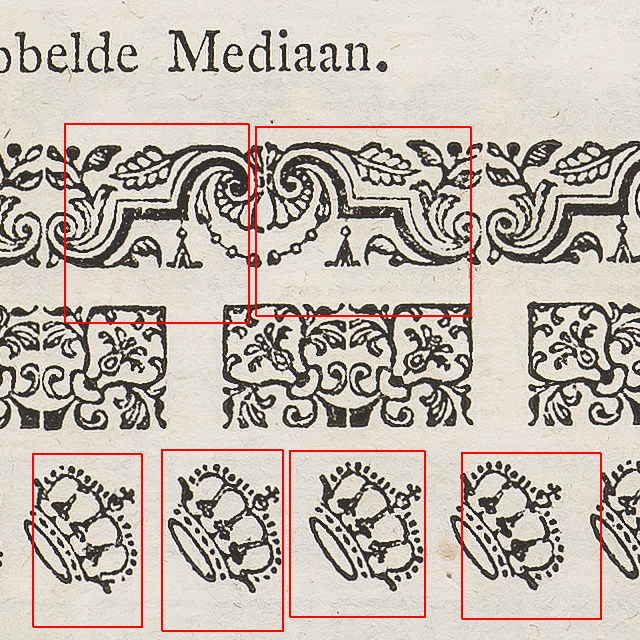

In [63]:
image

In [ ]:
test_im=Image.open("/content/1766_antiquite devoilee 4_0001 copie.jpg")

In [ ]:
test_im=test_im.resize((640,640))

In [ ]:
image,labels,scores,boxes=test(np.array(test_im))

In [ ]:
image

In [ ]:
scores

In [ ]:
boxes